<a href="https://colab.research.google.com/github/reggiebain/kaggle/blob/main/Exploring_College_Football_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring CFB API
- This notebook explores college football data using the API/data from https://collegefootballdata.com/ 
- Main Goals:
  - Calculate and plot basic ELO (k=25) ratings for any given team and any given conference
  - Visualize conference and team elo ratings over time and output data to Tableau
  - Create data wrangling functions to build towards creating ML model to generate power rankings and/or predict wins.

In [2]:
# Import college football api - https://github.com/CFBD/cfbd-python
!pip install cfbd;
!pip install seaborn --upgrade;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 14.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 288 kB 4.2 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [3]:
# Install API from college football data - https://blog.collegefootballdata.com/talking-tech-building-an-environment-for-predictive-analysis/ 
import cfbd

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'Ij+eNjYM+2AGnCzUarYtgy6ojR4W9W6iDuenMXna2jS+LmxUOHh6M1uBP+5NIz/Z'
configuration.api_key_prefix['Authorization'] = 'Bearer'

api_config = cfbd.ApiClient(configuration)


In [4]:
# Create a teams api instance and a games api instance and explore
teams_api = cfbd.TeamsApi(api_config)
#teams_api.get_fbs_teams()

games_api = cfbd.GamesApi(api_config)

In [5]:
import datetime
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

In [6]:
# Following - https://blog.collegefootballdata.com/talking-tech-elo-ratings/ 
def get_expected_score(rating, opp_rating):
    exp = (opp_rating - rating) / 400
    return 1 / (1 + 10**exp)

In [7]:
def get_new_elos(home_rating, away_rating, margin):
    k = 25

    # score of 0.5 for a tie
    home_score = 0.5
    if margin > 0:
        # score of 1 for a win
        home_score = 1
    elif margin < 0:
        #score of 0 for a loss
        home_score = 0

    # get expected home score
    expected_home_score = get_expected_score(home_rating, away_rating)
    # multiply difference of actual and expected score by k value and adjust home rating
    new_home_score = home_rating + k * (home_score - expected_home_score)

    # repeat these steps for the away team
    # away score is inverse of home score
    away_score = 1 - home_score
    expected_away_score = get_expected_score(away_rating, home_rating)
    new_away_score = away_rating + k * (away_score - expected_away_score)

    # return a tuple
    return (round(new_home_score), round(new_away_score))

In [8]:
def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

def elo_sort(team):
    return team['elo']

In [54]:
# Following guide, create list of dicts for each game, then sort by dates of games
games = []

for year in range(1992, 2022):
    response = games_api.get_games(year=year)
    games = [*games, *response]

games = [dict(
            start_date=g.start_date,
            home_team=g.home_team,
            home_conference=g.home_conference,
            home_points=g.home_points,
            away_team=g.away_team,
            away_conference=g.away_conference,
            away_points=g.away_points
            ) for g in games if g.home_points is not None and g.away_points is not None]
games.sort(key=date_sort)

In [55]:
games_df = pd.DataFrame(games)
games_df.head()
from google.colab import files
games_df.to_csv('all_games.csv') 
files.download('all_games.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
games[0]['away_points']

7

In [57]:
conferences = set([games[i]['home_conference'] for i in range(len(games))])

In [58]:
conferences

{'ACC',
 'AWC',
 'American Athletic',
 'Atlantic 10',
 'Big 12',
 'Big 8',
 'Big East',
 'Big Sky',
 'Big South',
 'Big Ten',
 'Big West',
 'CAA',
 'CIAA',
 'Conference USA',
 'ECFC',
 'FBS Independents',
 'FCS Independents',
 'GLIAC',
 'Great American',
 'Great Lakes',
 'Great Midwest Athletic',
 'Great Northwest',
 'Great West',
 'Gulf South',
 'Heartland',
 'Independent DII',
 'Ivy',
 'Lone Star',
 'MEAC',
 'MVFC',
 'Metro Atlantic Athletic',
 'Mid America',
 'Mid-American',
 'Mountain East',
 'Mountain West',
 'NEC',
 None,
 'North Coast',
 'Northeast 10',
 'Northern Sun',
 'Northwest',
 'OVC',
 'Pac-10',
 'Pac-12',
 'Patriot',
 'Pennsylvania State Athletic',
 'Pioneer',
 'Rocky Mountain',
 'SEC',
 'SIAC',
 'SWAC',
 'South Atlantic',
 'Southern',
 'Southern Athletic',
 'Southland',
 'Southwest',
 'Sun Belt',
 'Western Athletic'}

**Notes on Below**
- Following the example code, they set teams with no conference to 1200, but then teams with a conference to 1500, even though some of those teams are FCS.
- game['home_team'] goes from being a team name to an elo rating for some reason

In [59]:
# dict object to hold current Elo rating for each team
teams = dict()

# loop through games in order
for game in games:

    # get current rating for home team
    if game['home_team'] in teams:
        home_elo = teams[game['home_team']]
    elif game['home_conference'] is not None:
        # if no rating, set initial rating to 1500 for FBS teams
        home_elo = 1500
    else:
        # otherwise, set initial rating to 1200 for non-FBS teams
        home_elo = 1200

    # get current rating for away team
    if game['away_team'] in teams:
        away_elo = teams[game['away_team']]
    elif game['away_conference'] is not None:
        # if no rating, set initial rating to 1500 for FBS teams
        away_elo = 1500
    else:
        # otherwise, set initial rating to 1200 for non-FBS teams
        away_elo = 1200

    # calculate score margin from game
    margin = game['home_points'] - game['away_points']

    # get new elo ratings
    new_elos = get_new_elos(home_elo, away_elo, margin)

    # set pregame elos on game dict
    game['pregame_home_elo'] = home_elo
    game['pregame_away_elo'] = away_elo

    # set postgame elos on game dict
    game['postgame_home_elo'] = new_elos[0]
    game['postgame_away_elo'] = new_elos[1]

    # set current elo values in teams dict
    teams[game['home_team']] = new_elos[0]
    teams[game['away_team']] = new_elos[1]

In [60]:
teams['South Carolina']

1609

In [61]:
end_elos = [dict(team=key, elo=teams[key]) for key in teams]
end_elos.sort(key=elo_sort, reverse=True)

end_elos[:10]

[{'team': 'Alabama', 'elo': 2098},
 {'team': 'Ohio State', 'elo': 2022},
 {'team': 'Clemson', 'elo': 1988},
 {'team': 'Oklahoma', 'elo': 1968},
 {'team': 'Georgia', 'elo': 1961},
 {'team': 'Notre Dame', 'elo': 1935},
 {'team': 'Michigan', 'elo': 1852},
 {'team': 'LSU', 'elo': 1827},
 {'team': 'Oklahoma State', 'elo': 1822},
 {'team': 'Oregon', 'elo': 1820}]

**Visualizing ELO Over Time**
- [x] Issue: Need stable version of matplotlib not most recent

In [62]:
import matplotlib.pyplot as plt

# This is the styling I use. Check out other themes here: https://matplotlib.org/3.2.1/gallery/style_sheets/style_sheets_reference.html
plt.style.use('ggplot')

# Graph sizing
plt.rcParams["figure.figsize"] = [20,10]

In [63]:
def generate_chart(team):
    team_games = []
    for game in games:
        if game['home_team'] == team:
            team_games.append(dict(start_date=game['start_date'], elo=game['postgame_home_elo']))

        if game['away_team'] == team:
            team_games.append(dict(start_date=game['start_date'], elo=game['postgame_away_elo']))

    df = pd.DataFrame.from_records(team_games)
    fig, ax = plt.subplots()
    ax.plot(df.index, df['elo'])

    ax.set(xlabel='Game No.', ylabel='Elo Rating',
           title="Historical Elo Rating - {0}".format(team))

    plt.show()

In [64]:
teams = 'South Carolina'
sc_games = []
for game in games:
    if game['home_team'] == team:
        sc_games.append(dict(start_date=game['start_date'].split('T')[0], elo=game['postgame_home_elo']))

    if game['away_team'] == team:
        sc_games.append(dict(start_date=game['start_date'].split('T')[0], elo=game['postgame_away_elo']))

df = pd.DataFrame.from_records(sc_games)
df['start_date'] = pd.to_datetime(df['start_date'])
df.head()

,start_date,elo
0,1992-09-12,1513
1,1992-09-19,1525
2,1992-09-26,1537
3,1992-10-03,1523
4,1992-10-10,1511


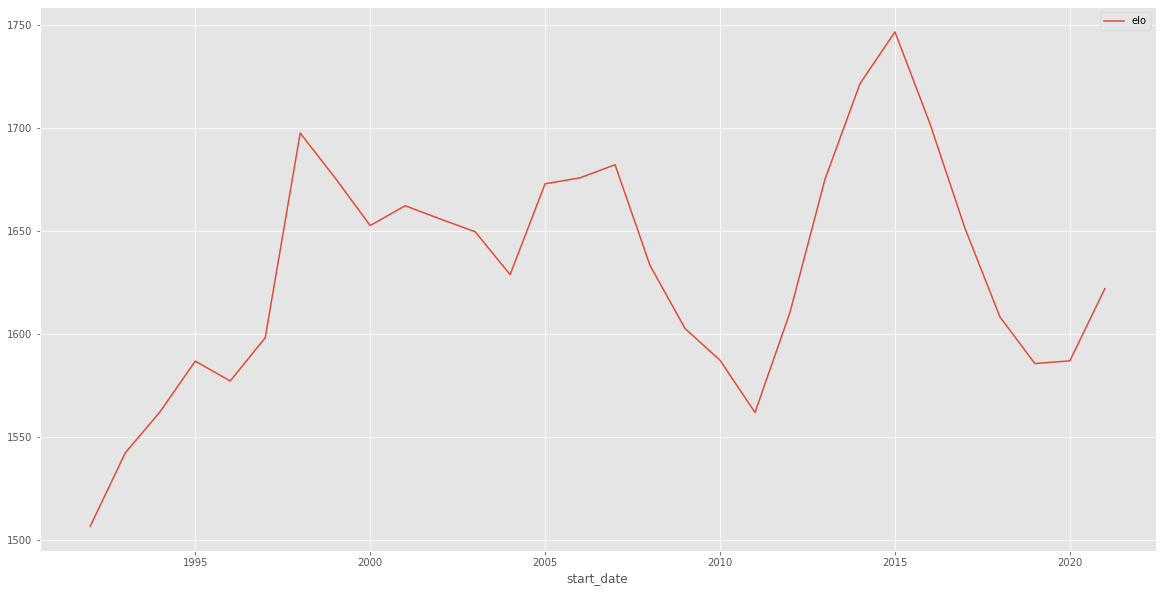

In [65]:
yearly_averages = pd.DataFrame(df.groupby(df.start_date.dt.year)['elo'].mean())
sns.lineplot(yearly_averages)

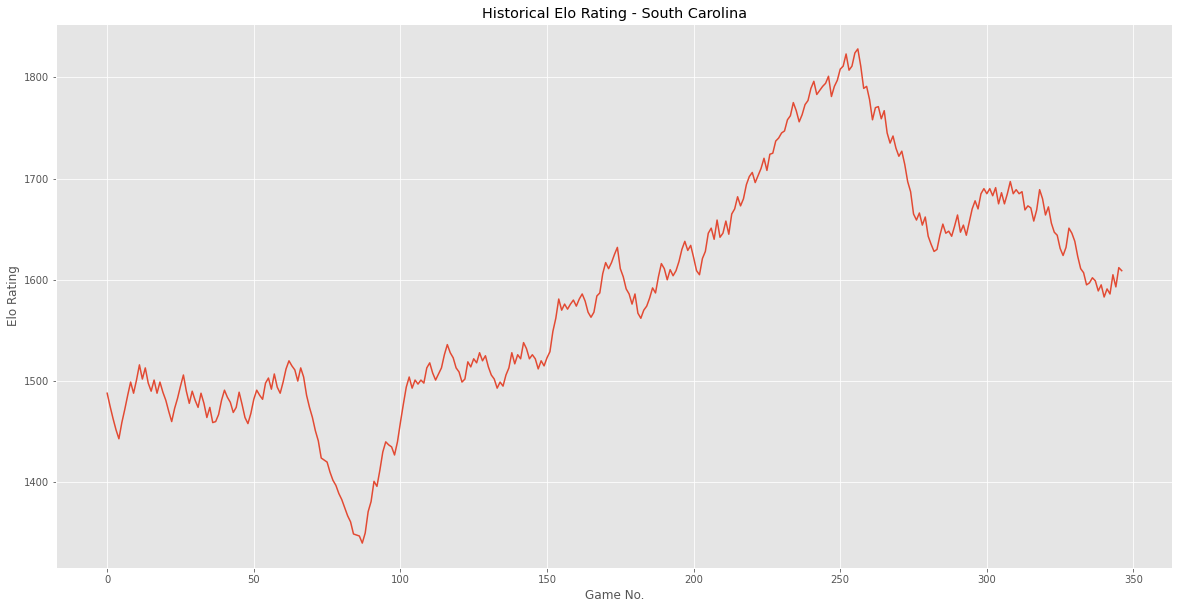

In [66]:
generate_chart('South Carolina')

### Quick Project
- Get average ELO of each major conferences over time

In [67]:
# Get totals for each conference
df_games = pd.DataFrame(games)
df_games.head()

,start_date,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo
0,1992-08-26T00:00:00.000Z,Texas A&M,Southwest,10,Stanford,Pac-10,7,1500,1500,1512,1488
1,1992-08-29T00:00:00.000Z,NC State,ACC,24,Iowa,Big Ten,14,1500,1500,1512,1488
2,1992-09-03T00:00:00.000Z,Bowling Green,Mid-American,29,Western Michigan,Mid-American,19,1500,1500,1512,1488
3,1992-09-03T00:00:00.000Z,Texas Tech,Southwest,9,Oklahoma,Big 8,34,1500,1500,1488,1512
4,1992-09-05T00:00:00.000Z,Colorado,Big 8,37,Colorado State,Western Athletic,17,1500,1500,1512,1488


elo
start_date conference             
1992       ACC         1510.994012
           Big 12      1507.232258
           Big Ten     1499.664516
           Pac-12      1516.947368
           SEC         1509.503226

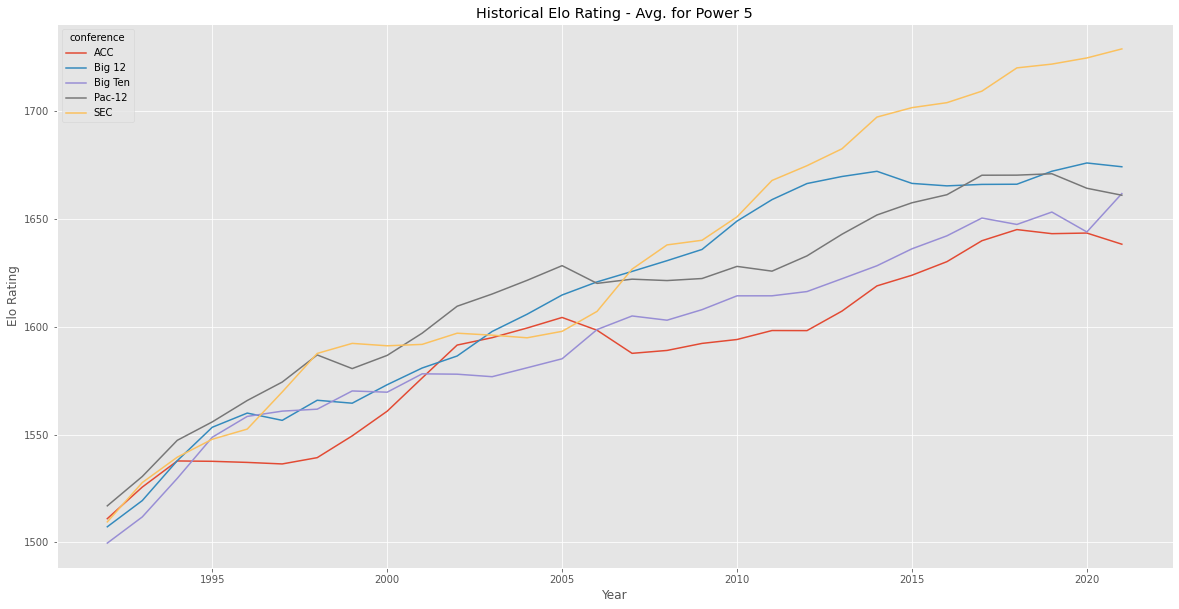

In [68]:
# Create plot of Elo Rating vs. Game Number.
import seaborn as sns
#fig, ax = plt.subplots()

conferences = ['SEC', 'ACC', 'Big 12', 'Big Ten', 'Pac-12']

all_games = []
for conference in conferences:
  conf_teams = df_games[df_games.home_conference == conference].home_team.unique()  
  for team in conf_teams:
    for game in games:
        if game['home_team'] == team:
            all_games.append(dict(start_date=game['start_date'].split('T')[0], elo=game['postgame_home_elo'], team=team, conference=conference))

        if game['away_team'] == team:
            all_games.append(dict(start_date=game['start_date'].split('T')[0], elo=game['postgame_away_elo'], team=team, conference=conference))

df = pd.DataFrame.from_records(all_games)

df['start_date'] = pd.to_datetime(df['start_date'])
#ax.plot(df.index, df['elo'])
yearly_averages = pd.DataFrame(df.groupby([df.start_date.dt.year, df.conference])['elo'].mean())
ax = sns.lineplot(data=yearly_averages, x='start_date', y='elo', hue='conference')
ax.set(xlabel='Year', ylabel='Elo Rating', title="Historical Elo Rating - Avg. for Power 5")
yearly_averages.head()
#df = pd.DataFrame.from_records(sc_games)
#df['start_date'] = pd.to_datetime(df['start_date'])
#df.head()

In [27]:
# Filter games to include SEC teams
df_games[(df_games.away_conference == 'SEC') | (df_games.home_conference == 'SEC')].head()


,start_date,home_team,home_conference,home_points,away_team,away_conference,away_points,pregame_home_elo,pregame_away_elo,postgame_home_elo,postgame_away_elo
6,2000-08-31T00:00:00.000Z,Auburn,SEC,35,Wyoming,Mountain West,21,1500,1500,1512,1488
17,2000-09-02T00:00:00.000Z,South Carolina,SEC,31,New Mexico State,Big West,0,1500,1500,1512,1488
23,2000-09-02T00:00:00.000Z,Ole Miss,SEC,49,Tulane,Conference USA,20,1500,1500,1512,1488
28,2000-09-02T00:00:00.000Z,Memphis,Conference USA,3,Mississippi State,SEC,17,1500,1500,1488,1512
37,2000-09-02T00:00:00.000Z,Vanderbilt,SEC,30,Miami (OH),Mid-American,33,1500,1500,1488,1512
